# MNIST Digits Classifier

In [1]:
### hide
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

Hide Base Path

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
#hide
Path.BASE_PATH = path

Get MNIST Data

In [4]:
train_path = path/'training'

train_path.ls()

(#10) [Path('training/2'),Path('training/7'),Path('training/5'),Path('training/3'),Path('training/8'),Path('training/6'),Path('training/0'),Path('training/1'),Path('training/4'),Path('training/9')]

In [5]:
twos = (train_path/'2').ls().sorted()
fives = (train_path/'5').ls().sorted()

print(twos[:2])
print(fives[:2])

[Path('training/2/10009.png'), Path('training/2/10016.png')]
[Path('training/5/0.png'), Path('training/5/100.png')]


Show Example Image

In [6]:
Image.open(twos[0])
#Image.open(fives[1])

In [7]:
t = tensor(Image.open(twos[0]))
tdf = pd.DataFrame(t[3:20,9:23])
tdf.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,128,128,191,255,255,255,0,0,0
2,0,0,0,191,255,255,255,255,255,255,255,128,0,0
3,0,0,128,255,255,255,255,255,128,191,255,255,64,0
4,0,0,128,255,255,255,191,64,0,64,255,255,128,0
5,0,0,0,64,128,64,0,0,0,128,255,255,128,0
6,0,0,0,0,0,0,0,0,0,128,255,255,128,0
7,0,0,0,0,0,0,0,0,0,255,255,255,0,0
8,0,0,0,0,0,0,0,0,191,255,255,191,0,0
9,0,0,0,0,0,0,0,0,255,255,255,0,0,0


Read Images into Tensor

In [8]:
two_tensors = [tensor(Image.open(two)) for two in twos]
five_tensors = [tensor(Image.open(five)) for five in fives]

In [9]:
two_t = torch.stack(two_tensors).float()/255
print(two_t.shape)
five_t = torch.stack(five_tensors).float()/255
print(five_t.shape)

print(f"Images with '2': {two_t.shape[0]}")
print(f"Images with '5': {five_t.shape[0]}")

torch.Size([5958, 28, 28])
torch.Size([5421, 28, 28])
Images with '2': 5958
Images with '5': 5421


## Baseline: Distance from Mean Image
Get Mean 2s and 5s over all Images

In [10]:
mean_two = two_t.mean(0)
mean_five = five_t.mean(0)

In [11]:
#Image.open(mean_two)
mean_two.shape
mean_five.shape

torch.Size([28, 28])

<Axes: >

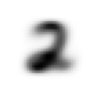

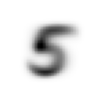

In [12]:
show_image(mean_two)
show_image(mean_five)

Calculate distance

In [13]:
def mse(im, mean):
    return ((im - mean)**2).mean((-1,-2)).sqrt()

#Equivalent to     
#F.mse_loss(two_t[1], mean_five).sqrt()

In [14]:
df = pd.DataFrame(index=[2,5],columns=['mse_2','mse_5'])

index = 2
df.iat[0,0] = float(mse(two_t[index],mean_two))
df.iat[0,1] = float(mse(two_t[index],mean_five))
df.iat[1,0] = float(mse(five_t[index],mean_two))
df.iat[1,1] = float(mse(five_t[index],mean_five))

df

,mse_2,mse_5
2,0.245812,0.25939
5,0.297486,0.244533


Baseline is working!
Numbers have lower loss for their corresponding mean numbers

Now: Measure Accuracy for each Number

In [15]:
def pred(t):
    two_score = F.mse_loss(t, mean_two).sqrt()
    five_score = F.mse_loss(t, mean_five).sqrt()
    scores = [two_score,five_score]
    return ['2','5'][scores.index(min(scores))]

In [16]:
mse_valid_two = mse(two_t,mean_two)
mse_invalid_two = mse(two_t,mean_five)

mse_invalid_five = mse(five_t,mean_two)
mse_valid_five = mse(five_t,mean_five)

Get Accuracy of Baseline

In [17]:
first_is_lower = lambda a, b: a < b

twos_acc = first_is_lower(mse_valid_two,mse_invalid_two).float().mean()
fives_acc = first_is_lower(mse_valid_five,mse_invalid_five).float().mean()

print(f"Accuracy '2': {twos_acc:.4f}")
print(f"Accuracy '5': {fives_acc:.4f}")

print(f"Can a neural network do better?")

Accuracy '2': 0.9483
Accuracy '5': 0.9629
Can a neural network do better?


Show wrongly classified '2's

<Axes: >

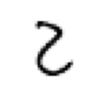

In [18]:
twos_res = first_is_lower(mse_valid_two,mse_invalid_two).float().tolist()
wrong_ind = [index for index, x in enumerate(twos_res) if x == 0.0]
show_image(two_t[wrong_ind[1]])

## Neural Network Classifier

Create DataLoader for Input Data

Transform 2D-Images to 1D-Tensor(Vector)
(_Note_) -1 makes first axis _as big as necessary_ to fit the data

Label for one dataset: ```[x , y] x:= "2", y:="5"``` \
e.g. ```[True,False] is a label for 2```

In [25]:
# Combine training data
train_x = torch.cat([two_t,five_t]).view(-1, 28*28)

# Add Labels
train_y = torch.zeros(train_x.shape[0], 2, dtype=float) 
train_y[:two_t.shape[0], 0] = 1.0
train_y[two_t.shape[0]:, 1] = 1.0

dset = list(zip(train_x,train_y))

Print image and label from dataset (dset)

image index:	 5958
label:		 tensor([0., 1.], dtype=torch.float64)


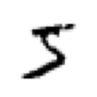

In [29]:
index = two_t.shape[0]
ig = dset[0][0]
label = dset[index][1]
show_image(dset[index][0].view(28,28))
print(f"image index:\t {index}")
print(f"label:\t\t {label}")

Save in DataLoader

In [30]:
dl = DataLoader(dset, batch_size=5, shuffle=True)

Minibatch of size 5

In [31]:
item = next(iter(dl))
item

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.]], dtype=torch.float64))

In [32]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,2)
)

dls = DataLoaders(dl)
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)
learn.fit(5,lr=0.01)


#learn = vision_learner(dl, resnet18, pretrained=False, loss_func=F.mse_loss, metrics=accuracy)
#doc(F.mse_loss)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Exception occured in `Recorder` when calling event `after_batch`:
	expected dtype double for `end` but got dtype float

In [ ]:
index = two_t.shape[0] 
ig = dset[22][0]
label = dset[index][1]

In [ ]:
label = item[1][3]
label

In [ ]:
pred = torch.tensor([[0.0011, 0.99],[0.80,0.2]])  # Model outputs (logits or probabilities)
label = torch.tensor([1,1])  # True label (index 0)

# Compute cross-entropy loss
loss = F.cross_entropy(pred, label)

print("Cross-Entropy Loss:", loss.item())

In [ ]:
#dls = ImageDataLoaders.from_folder(path)
path.ls()